# Particle tracking for vulnerability analysis, a synthetic model

This tutorial presents the capabilities of the `tracktools` python package for vulnerability analysis of production wells or drains. `tracktools` is designed for `MODFLOW6` and `MODPATH7`. The illustration is based on a synthetic groundwater flow model with an unstructured quad-tree grid.

### Notebook environment setup

In [1]:
# ---- set local settings 
import os, sys

sys.path.append(os.path.join(os.getcwd(),'..'))
gis_dir = 'gis'
exe_dir = os.path.join('..','exe')
#gridgen_exe = os.path.join(exe_dir, 'gridgen')
#mf6_exe = os.path.join(exe_dir, 'mf6')
#mp7_exe = os.path.join(exe_dir, 'mp7')
mf6_exe = 'gridgen'
mf6_exe = 'mf6'
mp7_exe = 'mp7'

# ---- Import packages
import numpy as np
import pandas as pd
import shapely
from shapely import speedups
speedups.disable()

import flopy
from flopy.utils.gridgen import Gridgen
from flopy.export.shapefile_utils import shp2recarray

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
plt.rc('font', family='serif', size=7)
mpl.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore")

# ---- Print used version of each packages
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

3.8.2 (v3.8.2:7b3ab5921f, Feb 24 2020, 17:52:18) 
[Clang 6.0 (clang-600.0.57)]
numpy version: 1.21.2
flopy version: 3.3.5
matplotlib version: 3.3.4


### Case description

We consider an heterogeneous aquifer in a `3.75 km x 5 km` rectangle domain with production wells *w1* and *w2*, and a drain *d1*, surrounded by a series of contaminated zones (*z1*, *z2*, *z3*). The aquifer interacts with a river, which may also be a source of contamination. A constant head condition is set on the southern border. The river is divided into 3 reaches : *r1*, *r2*, *r3*. Spatial discretisation is DISV with a `50x50m` base grid resolution with nested refinements in the vicinity of river reaches, wells and drains. 

### Loading existing ground water flow model

The Modflow6 files of the model have been created in the `ml` folder with the `ml_setup.py` script. 

In [2]:
# ---- Load simulation object
ml_dir ='ml'
sim = flopy.mf6.MFSimulation.load(sim_ws=ml_dir)

# ---- Set mf6 executable
sim.exe_name = mf6_exe

# ---- Load ModflowGwf model
gwf = sim.get_model('syn_model')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package ghb...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package wel...
    loading package oc...
  loading ims package syn_model...


#### Run ground water flow model

In [3]:
sim.run_simulation()

FloPy is using the following executable to run the model: /Users/apryet/Programmes/modflow/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled Mar  4 2022 18:19:04 with GFORTRAN compiler (ver. 6.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USG

(True, [])

#### Plot heads results 

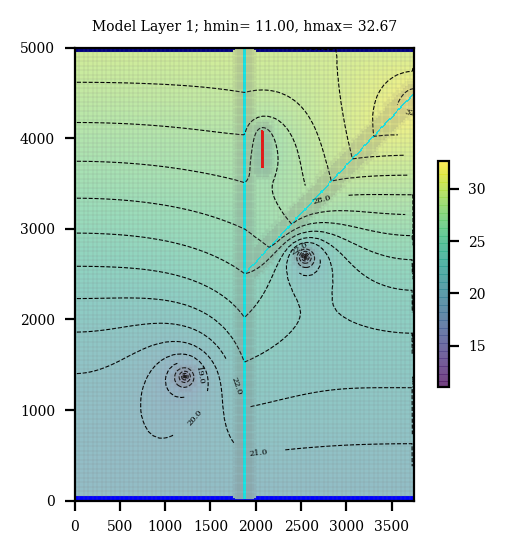

In [4]:
# get head data
ilay = 0
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,ilay,-1,:]

# figure settings
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.tick_params(axis='both', which='major', labelsize=5)

# build MapPlotView object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)

# plot head data
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)
cb.ax.tick_params(labelsize=5)

# plot contours
hmin, hmax = hds.min(), hds.max()
levels = np.arange(np.floor(hmin), np.ceil(hmax), 1)
contours = pmv.contour_array(hds, masked_values=[1.e+30], 
                                  levels=levels, linewidths = 0.4,
                                  linestyles = 'dashed', colors = 'black')
contours.clabel(fmt = '%1.1f', inline=True, colors = 'black', inline_spacing = 20, fontsize = 3)

# set boundaries colors
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'GHB': 'navy', 'WEL': 'coral', 'CHD':'blue'}
for bc in bc_colors_dic.keys():
        quadmesh = pmv.plot_bc(bc, color = bc_colors_dic[bc])
        
# set title
ax.set_title('Model Layer {}; hmin={:6.2f}, hmax={:6.2f}'.format(ilay + 1, hmin, hmax), fontsize = 5)

# plot grid
pmv.plot_grid(lw = 0.03)

### Seeding particles  

The `ParticleGenerator` class generates particles process data required by `mp7`. A `ParticleGenerator` instance is initialized with an instance of `flopy.mf6.mfmodel.MFModel` which contains model grid data.

In [5]:
from tracktools import ParticleGenerator

pg = ParticleGenerator(ml = gwf)

Starting particle locations (points) can be seeded with the `.gen_points()` method along the borders of selected model cells where a sink term is applied (e.g. well or drain package).

The `obj` argument of the `.gen_points()` can be :
 - dict of cells *(ex: `{'w1': [343], 'd1': [521, 522, 523]}`)*
 - dict of shapely geometries *(ex: `{'w1': shapely.geometry.Point(x,y)}`)*
 - str : shapefile path *(ex: `/gis/wells.shp`)*
When a geometry or a shapefile is provided, seeding is conducted around the series of intersected cells.

When `export` is True, `gen_points()` writes a shapefile with seeded particles.

In [6]:
# generate points from model cell for well w1
well_spd = gwf.wel.stress_period_data.get_data(0)
w1_layer, w1_node = well_spd[well_spd['boundname'] == 'w1']['cellid'][0]
pg.gen_points({'w1':w1_node}, n = 30)
pg.particledata.tail()

,fid,node,lx,ly,pid,geometry
25,w1,11067,1.0,0.448276,25,POINT (2537.5 2693.103448275862)
26,w1,11067,1.0,0.586207,26,POINT (2537.5 2694.827586206897)
27,w1,11067,1.0,0.724138,27,POINT (2537.5 2696.551724137931)
28,w1,11067,1.0,0.862069,28,POINT (2537.5 2698.275862068966)
29,w1,10798,1.0,0.000000,29,POINT (2537.5 2700)


In [7]:
# generate points are well W2 from shapely geometry
well_shpfile = os.path.join('gis','wells.shp')
wells_df = pd.DataFrame(shp2recarray(well_shpfile))
wells_geom = wells_df.loc[wells_df.FID=='w2','geometry'].iloc[0]

w2_layer, w2_node = well_spd[well_spd['boundname'] == 'w2']['cellid'][0]

pg.gen_points({'w2':w2_node}, n = 30)
pg.particledata.tail()

,fid,node,lx,ly,pid,geometry
55,w2,14966,1.0,0.448276,55,POINT (1212.5 1368.103448275862)
56,w2,14966,1.0,0.586207,56,POINT (1212.5 1369.827586206897)
57,w2,14966,1.0,0.724138,57,POINT (1212.5 1371.551724137931)
58,w2,14966,1.0,0.862069,58,POINT (1212.5 1373.275862068966)
59,w2,14960,1.0,0.000000,59,POINT (1212.5 1375)


In [8]:
# generate particles around wells and drains from shapefiles
#pg.remove_particledata()

# NOTE : TEMPORARY 
#pg.gen_points(well_shpfile, n = 10, id_field='FID')

# generate particles from shapefile 
drn_shpfile = os.path.join('gis','drain.shp')
pg.gen_points(drn_shpfile, n = 50, id_field='FID',export='drn_parts.shp')
pg.particledata.tail(5)

No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.(writing .prj files from proj4 strings not supported)
wrote drn_parts.shp


,fid,node,lx,ly,pid,geometry
105,d1,5911,1.0,0.122449,105,POINT (2062.5 3676.530612244898)
106,d1,5909,1.0,0.591837,106,POINT (2062.5 3694.897959183673)
107,d1,5614,1.0,0.061224,107,POINT (2062.5 3713.265306122449)
108,d1,5608,1.0,0.530612,108,POINT (2062.5 3731.632653061225)
109,d1,5313,1.0,0.000000,109,POINT (2062.5 3750)


The generated points stored some usefull information for `Modpath7` simulation such as:
  - `node` : node number of the cell in which the point was generated
  - `local_x` : x-coordinate of the points into the cell
  - `local_y` : y-coordinate of the points into the cell
  - `pid` : unique particle id

#### Plot generated particles around a well

(1352.226211849192, 1382.226211849192)

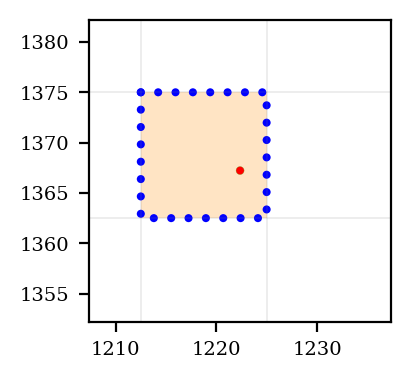

In [9]:
well_id = 'w2'

# convert particles to geometry collection
partset = pg.particledata.loc[pg.particledata.fid==well_id].geometry.to_list()
partset_collection = flopy.utils.geometry.Collection(partset)

# plot well "W1" with starting points and model grid
fig, ax = plt.subplots(figsize=(2,2))
ax.set_aspect('equal')

pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0.05)
pmv.plot_bc('WEL', color = 'bisque')
pmv.plot_shapes(partset_collection,radius=0.40,lw=0,facecolor='blue')
pmv.plot_shapefile(well_shpfile,radius=0.40,lw=0.1,facecolor='red')


# zoom to well cell
wells_df = pd.DataFrame(shp2recarray(well_shpfile))
x0 = wells_df.loc[wells_df.FID==well_id].geometry.iloc[0].x
y0 = wells_df.loc[wells_df.FID==well_id].geometry.iloc[0].y
wd = 15.
ax.set_xlim(x0-wd,x0+wd)
ax.set_ylim(y0-wd,y0+wd)

#### Plot generated particles around the drain

(3625.0, 4125.0)

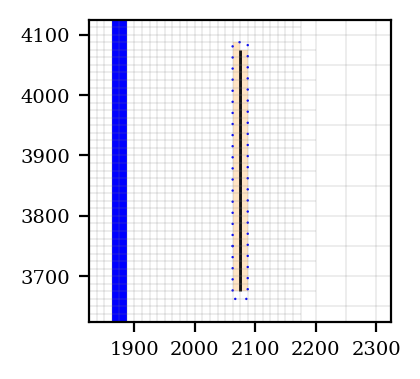

In [10]:
# convert particles to geometry collection
partset = pg.particledata.loc[pg.particledata.fid=='d1'].geometry.to_list()
partset_collection = flopy.utils.geometry.Collection(partset)

# plot well "W1" with starting points and model grid
fig, ax = plt.subplots(figsize=(2,2))
ax.set_aspect('equal')

pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0.05)
pmv.plot_bc('DRN', color = 'bisque')
pmv.plot_bc('RIV', color = 'blue')
pmv.plot_shapes(partset_collection,radius=2.,lw=0,facecolor='blue')
pmv.plot_shapefile(drn_shpfile,lw=1,edgecolor='black')

# zoom to well cell
drn_df = pd.DataFrame(shp2recarray(drn_shpfile))
xmin,ymin,xmax,ymax = drn_df.loc[drn_df.FID=='d1'].geometry[0].bounds
x0,y0 = (xmax+xmin)/2 , (ymax+ymin)/2 
wd = 250.
ax.set_xlim(x0-wd,x0+wd)
ax.set_ylim(y0-wd,y0+wd)

#### Build ParticleGroups

The `get_particlegroups` method returns a list of `flopy.modpath.mp7particlegroup.ParticleGroup` instances. The `pgid_file` allows the user to write a simple external text file with the correspondance between numerical particle group ids and particle group names.

In [11]:
# ---- Build MODPATH7 ParticleGroup instances
pgid_file = os.path.join(gwf.model_ws , 'pgroups.csv')
particlegroups = pg.get_particlegroups(pgid_file=pgid_file)

###  PART 5 : Build & Run backward particle tracking model

#### Build MODPATH7 Model 

In [37]:
# ---- Choose a name for modpath model
mpname =  'mp_rv'

# ---- Build MODPATH7 model instance
mp = flopy.modpath.Modpath7(modelname= mpname, flowmodel= gwf,
                            model_ws = ml_dir, exe_name= mp7_exe)

# ---- Set default iface for MODFLOW 6
defaultiface6 = {'RCH': 6, 'EVT': 6}

# ---- Build MODPATH7 BAS package
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1, defaultiface=defaultiface6)

# ---- Build MODPATH7 SIM package
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline',
                                      trackingdirection='backward',
                                      weaksinkoption='stop_at',
                                      weaksourceoption='stop_at',
                                      budgetoutputoption='no',
                                      stoptimeoption='extend',
                                      particlegroups= particlegroups)

#### Write and Run MODPATH7 simulation

In [38]:
# ---- Write modpath files
mp.write_input()

# ---- Run modpath
mp.run_model()

FloPy is using the following executable to run the model: /Users/apryet/Programmes/modflow/bin/mp7

MODPATH Version 7.2.001   
Program compiled Apr  2 2020 22:09:01 with GFORTRAN compiler (ver. 6.3.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
       110 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Plot pathlines

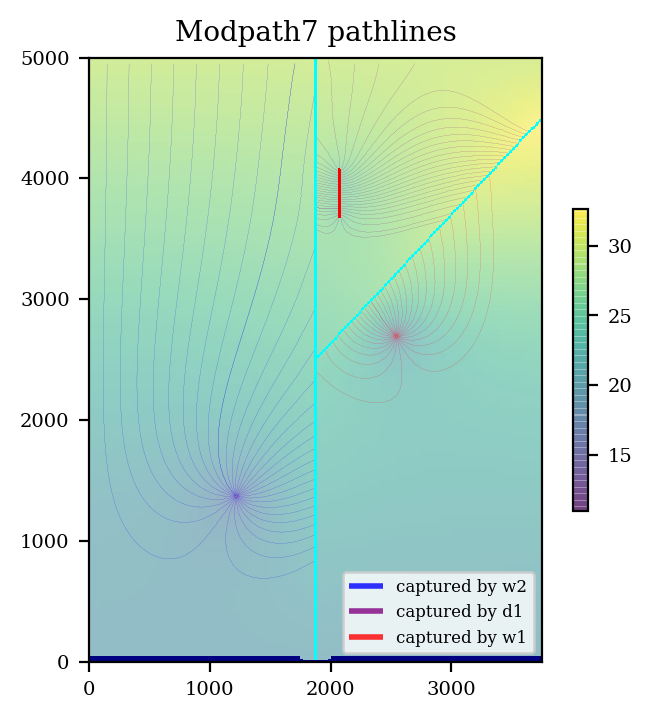

In [39]:
# ---- Prepare axes for plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Modpath7 pathlines' , fontsize=10)
 
# ---- Create Plot Map View object
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
pmv.plot_grid(lw = 0)
    
# ---- Plot heads as background
hds = sim.simulation_data.mfdata[gwf.name,'HDS','HEAD'][-1,-1,-1,:]
heads = pmv.plot_array(hds, masked_values=[1.e+30], alpha=0.5)
cb = plt.colorbar(heads, shrink = 0.5)

# ---- Plot pathlines for each group
pth = flopy.utils.PathlineFile(os.path.join(ml_dir,mpname + '.mppth'))
colors = ['blue', 'purple', 'red']
for pgrp, c in zip(particlegroups, colors):
    nodes = pgrp.particledata.particledata.node
    rec = pth.get_destination_pathline_data(nodes) 
    pmv.plot_pathline(rec, color = c, layer = 'all', lw = 0.03, alpha = 0.8,
                    label=f'captured by {pgrp.particlegroupname}')
# ---- Plot boundaries
bc_colors_dic = { 'RIV': 'cyan', 'DRN': 'red', 'CHD': 'navy', 'WEL': 'coral'}
for bc in bc_colors_dic.keys():
    bounds = pmv.plot_bc(bc, color = bc_colors_dic[bc])
    
# ---- Plot legend
leg = ax.legend(loc = 'lower right',fontsize = 6)
for line in leg.get_lines():
    line.set_linewidth(2)

### PART 6 : River vulnerability

We'll now assume that the river is contaminated and investigate the vulnerability of production units (wells and drain) with the `TrackingAnalyzer` 
This class can be initialized:
- from FloPy objects
    - `gwf`: the ground water flow model (`flopy.mf6.mfmodel.MFModel`) 
    - `mpsim`: the advective transport simulation (`flopy.modpath.mp7sim.Modpath7Sim`)
- from output files
    - `endpoint_file` : the resulting endpoint file of MODPATH simulation
    - `pathline_file` : the resulting pathline file of MODPATH simulation
    - `cbc_file` : the resulting `cell-by-cell` binary file of the MODFLOW simulation
    - `grb_file` : the binary `grb` file of the flowmodel

In [44]:
from tracktools import TrackingAnalyzer

# ---- Initialize TrackingAnalyzer (from FloPy objects)
ta = TrackingAnalyzer(ml = gwf, mpsim = mpsim)


'''

# ---- Initialize TrackingAnalyzer (from output files)
edpf = os.path.join('ml', 'mp_rv.mpend')
pthf = os.path.join('ml', 'mp_rv.mppth')
cbcf = os.path.join('ml', 'syn_model.cbc')
grdf = os.path.join('ml', 'syn_model.disv.grb')
pgrpf = os.path.join('ml', 'pgroups.csv')
rivf = os.path.join('ml', 'rivnames.csv')

ta = TrackingAnalyzer(endpoint_file=edpf, pathline_file=pthf,
                      cbc_file = cbcf, grb_file = grdf)
ta.load_pgrp_names(pgrpf)
ta.load_rivname_dic(rivf)
'''

"\n\n# ---- Initialize TrackingAnalyzer (from output files)\nedpf = os.path.join('ml', 'mp_rv.mpend')\npthf = os.path.join('ml', 'mp_rv.mppth')\ncbcf = os.path.join('ml', 'syn_model.cbc')\ngrdf = os.path.join('ml', 'syn_model.disv.grb')\npgrpf = os.path.join('ml', 'pgroups.csv')\nrivf = os.path.join('ml', 'rivnames.csv')\n\nta = TrackingAnalyzer(endpoint_file=edpf, pathline_file=pthf,\n                      cbc_file = cbcf, grb_file = grdf)\nta.load_pgrp_names(pgrpf)\nta.load_rivname_dic(rivf)\n"

In [45]:


from flopy.utils import EndpointFile, PathlineFile, CellBudgetFile

cbcf = os.path.join('ml', 'syn_model.cbc')
cbc = CellBudgetFile(cbcf)
riv_leak_df = pd.DataFrame(cbc.get_data(text='RIV')[0])
riv_leak_df['node'] = riv_leak_df['node'] - 1 
riv_leak_df.set_index('node', drop=False, inplace=True)

print(riv_leak_df)

print(ta.compute_mixing_ratio(on='river'))

v = ta.get_part_velocity()
print(v.max())

        node  node2         q
node                         
62        62      1  0.000019
11819  11819      2  0.000037
65        65      3  0.000019
64        64      4  0.000015
11664  11664      5  0.000022
...      ...    ...       ...
15438  15438   1094  0.000082
15578  15578   1095  0.000058
15577  15577   1096  0.000081
15441  15441   1097  0.000058
15575  15575   1098  0.000082

[1098 rows x 3 columns]
src       others     river
grpnme                    
d1      0.523927  0.476073
w1      0.404769  0.595231
w2      0.676210  0.323790
v    0.000193
dtype: float32


#### Compute mixing ratios

`TrackingAnalyzer` object allows computing the fraction of water that comes from the river at a given production facility like a well or a drain. The value of the mixing ratio may range between **`0`** (ground water only) to **`1`** (surface water only).

For going further about mixing ratios : [Cousquer et al, 2018](https://hal.archives-ouvertes.fr/hal-02308252/ "Developing a particle tracking surrogate model to improve inversion of ground water Surface water models")

The mixing ratio computation can be performed on:
   - all river boundaries for each particle group (`on = 'river'`, *default*)
   - river reaches (`on = 'reaches'`)
   - groups of river reaches (`on = {reach_group: ['reach1', 'reach2', ...]}`)

Note: before computing mixing ratios on reaches make sure river reache's names had been provided in `.rivname_dic`. Otherwise, consider using the `.load_rivname_dic()` method (especially for external handling).  

In [46]:
# ---- Compute mixing ratio on all river  
mr_df = ta.compute_mixing_ratio(on='river')

# ---- Transform to percent
mr_df_river = mr_df * 100
print(mr_df_river.round(decimals = 2).to_markdown(tablefmt='github'))

| grpnme   |   others |   river |
|----------|----------|---------|
| d1       |    52.39 |   47.61 |
| w1       |    40.48 |   59.52 |
| w2       |    67.62 |   32.38 |


In [47]:
# ---- Compute mixing ratio on reaches 
mr_df = ta.compute_mixing_ratio(on='reach')

# ---- Transform to percent
mr_df_reach = mr_df * 100
print(mr_df_reach.round(decimals = 2).to_markdown(tablefmt='github'))

| grpnme   |    R1 |    R2 |    R3 |   others |
|----------|-------|-------|-------|----------|
| d1       | 24.02 | 23.59 |  0    |    52.39 |
| w1       |  0    | 57.7  |  1.82 |    40.48 |
| w2       |  1.01 |  0    | 31.37 |    67.62 |


#### Plot mixing ratio results

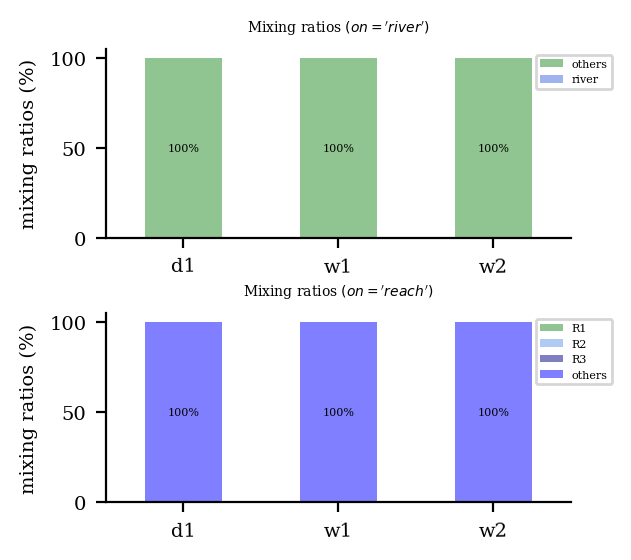

In [18]:
# ---- Prepare plot area
fig, axes = plt.subplots(2,1, figsize=(3,3), gridspec_kw={'hspace':0.4} )
colors = [['forestgreen', 'royalblue'],
          ['forestgreen', 'cornflowerblue', 'navy','blue']]

for ax, df, c in zip(axes, [mr_df_river, mr_df_reach], colors):
    df_sorted = df.sort_values('others')
    df_sorted.plot.bar(ax=ax,color=c, stacked=True, alpha = 0.5, rot = 1)
    ax.set_ylabel('mixing ratios (%)')
    ax.set_xlabel('')
    if len(c) == 2:
        ax.set_title("Mixing ratios $(on = 'river')$", fontsize = 5)
    else: 
        ax.set_title("Mixing ratios $(on = 'reach')$", fontsize = 5)
    # ---- Add % value labels
    for p in ax.patches:
        # Write text only for % > 2
        if p.get_height() > 2:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.text(x+width/2, y+height/2, '{:.0f}%'.format(height),
            fontsize = 4, ha='center', va='center')
        # ---- Hide axis
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ---- Add legend
        ax.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1), fontsize = 4) 


#### Aggregate reaches

`TrackingAnalyzer` object allows computing mixing ratios aggregating multiple river reaches. Let's try to aggregate  reaches considering the `r2` reach as a `tributary` and the others reaches as the `main` river.

In [19]:
# ---- Create a aggregation dictionary
agg_dic = {'main' : [r for r in ta.rivname_dic.keys() if r != 'r2'],
           'tributary' : 'r2'}

# ---- Compute mixing ratio again
mr = ta.compute_mixing_ratio(on = agg_dic)

# ---- Transform to percent
mr_df = mr * 100
print(mr_df.round(decimals = 2).to_markdown(tablefmt='github'))

| grpnme   |   R1 |   R2 |   R3 |   others |
|----------|------|------|------|----------|
| d1       |  nan |  nan |    0 |      100 |
| w1       |    0 |  nan |  nan |      100 |
| w2       |  nan |    0 |  nan |      100 |
